## Imports Modules

In [1]:
# Uncomment the following to install them if not yet have them
! pip install matplotlib-venn
# !pip install numpy==1.23.5
# !pip install pandas==1.5.3
# !pip install seaborn==0.11.2
# !pip install lightgbm==3.3.5
# !pip install xgboost==1.7.5

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb
seed=777

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer,KNNImputer

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error

In [3]:
#Check versions of installed modules
#print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
#print(f"Scikit-Learn version: {sklearn.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")

NumPy version: 1.23.5
Pandas version: 1.5.3
Seaborn version: 0.11.2
LightGBM version: 3.3.5
XGBoost version: 1.7.5


## Data Loading

In [24]:
# Load data from CSV files into DataFrames

# Load the 'pcp_df' DataFrame from the specified CSV file
pcp_df = pd.read_csv(r"imgs_202307101549519358.csv")

# Load the 'cl_df' DataFrame from the specified CSV file
cl_df = pd.read_csv(r"imgs_2023071012130978799.csv")

# Load the 'bs_df' DataFrame from the specified CSV file
bs_df = pd.read_csv(r"imgs_2023071012123392536.csv")

# Load the 'ec_df' DataFrame from the specified CSV file
ec_df = pd.read_csv(r"imgs_2023071012133740345.csv")

# Load the 'ss_df' DataFrame from the specified CSV file
ss_df = pd.read_csv(r"SampleSubmission.csv")

# Print the shapes (number of rows and columns) of each DataFrame
pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, #ss_df.shape

((26139, 4), (125575, 10), (1217, 8), (92629, 3))

In [5]:
pcp_df['w'].value_counts()

1    23189
5     2950
Name: w, dtype: int64

## Data Pre-Processing

In [6]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [7]:
cl_df.head(2)

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0


In [8]:
bs_df.head(2)

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.00,20,4,6.875934
1,B_0,Cell1,Type1,Mode2,426.98,2,4,7.327504


In [9]:
result = (bs_df.groupby(['BS', 'CellName'])['RUType'].nunique() == 1).sum()
print(result)
print(len(bs_df))

# Filter the DataFrame to get rows where the condition is not met
rows_with_condition_not_met = bs_df[~(bs_df.groupby(['BS', 'CellName'])['RUType'].transform('nunique') == 1)]

# Display the rows where the condition is not met
print(rows_with_condition_not_met)

1217
1217
Empty DataFrame
Columns: [BS, CellName, RUType, Mode, Frequency, Bandwidth, Antennas, TXpower]
Index: []


In [10]:
result = (bs_df.groupby(['BS', 'CellName'])['Mode'].nunique() == 1).sum()
print(result)
print(len(bs_df))

# Filter the DataFrame to get rows where the condition is not met
rows_with_condition_not_met = bs_df[~(bs_df.groupby(['BS', 'CellName'])['Mode'].transform('nunique') == 1)]

# Display the rows where the condition is not met
print(rows_with_condition_not_met)

1217
1217
Empty DataFrame
Columns: [BS, CellName, RUType, Mode, Frequency, Bandwidth, Antennas, TXpower]
Index: []


In [11]:
# Calculate the count of unique 'Antennas' values per group of 'BS' and count how many times the count is 1
result = (bs_df.groupby(['BS'])['Antennas'].nunique() == 1).sum()

# Print the result
print(result)

# Print the total number of rows in the 'bs_df' DataFrame
print(len(bs_df))

# Filter the DataFrame to get rows where the condition is not met (unique 'Antennas' count is not 1)
rows_with_condition_not_met = bs_df[~(bs_df.groupby(['BS'])['Antennas'].transform('nunique') == 1)]

# Display the rows where the condition is not met
print(rows_with_condition_not_met)

1011
1217
        BS CellName RUType   Mode  Frequency  Bandwidth  Antennas   TXpower
131  B_172    Cell0  Type1  Mode2     365.00         20         4  6.875934
132  B_172    Cell1  Type1  Mode2     426.98          2         2  6.877429
134  B_174    Cell0  Type1  Mode2     365.00         20         4  6.875934
135  B_174    Cell1  Type1  Mode2     426.98          2         2  6.877429
142  B_180    Cell0  Type1  Mode2     365.00         20         4  6.875934
143  B_180    Cell1  Type1  Mode2     426.98          2         2  6.877429
645  B_555    Cell0  Type1  Mode2     365.00         20         4  6.875934
646  B_555    Cell1  Type1  Mode2     426.98          2         2  6.877429
648  B_557    Cell0  Type1  Mode2     365.00         20         4  6.875934
649  B_557    Cell1  Type1  Mode2     426.98          2         2  6.877429
656  B_563    Cell0  Type1  Mode2     365.00         20         4  6.875934
657  B_563    Cell1  Type1  Mode2     426.98          2         2  6.877429
71

In [12]:
BSinfo_conf=bs_df.groupby("BS",as_index=False)["Antennas"].nunique().sort_values(by="Antennas",ascending=False)#.head()
BSinfo_conf=BSinfo_conf[BSinfo_conf["Antennas"]>1]
print(len(BSinfo_conf))
BSinfo_conf_=BSinfo_conf.BS
#BSinfo_conf

for Id in BSinfo_conf_.tolist():
    bs_df.loc[bs_df["BS"]==Id]=2

9


In [13]:
ec_df.head(2)

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335


In [14]:
pcp_df.head(2)

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1


In [15]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

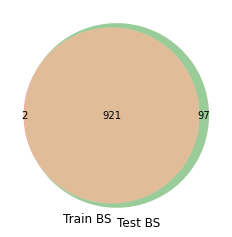

In [16]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [17]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [18]:
cl_df=cl_df.merge(ec_df, on=['time', 'bs'], how='left')
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
print("Length of CLdata_ECdata: ",cl_bs_df.shape,"\n")
cl_bs_df.head()
#cl_bs_df[cl_bs_df['bs'] == 'B_0']

Length of CLdata_ECdata:  (125575, 17) 



,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,energy,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,64.275037,Type1,Mode2,365.0,20.0,4.0,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,55.904335,Type1,Mode2,365.0,20.0,4.0,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,57.698057,Type1,Mode2,365.0,20.0,4.0,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,55.156951,Type1,Mode2,365.0,20.0,4.0,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,56.053812,Type1,Mode2,365.0,20.0,4.0,6.875934


In [19]:
cl_bs2=cl_bs_df.groupby('bs')[['cellname', 'load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'rutype', 'mode', 'frequency',
       'bandwidth', 'antennas', 'txpower']].last().reset_index()
#cl_bs2['bs2']=cl_bs2['bs']
cl_bs2.head()

,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,B_0,Cell1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,Type1,Mode2,426.98,2.0,4.0,7.327504
1,B_1,Cell0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,Type2,Mode2,532.00,20.0,4.0,6.875934
2,B_10,Cell1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,Type1,Mode2,426.98,2.0,2.0,7.323617
3,B_100,Cell0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934
4,B_1000,Cell0,0.081519,0.0,0.0,0.0,0,0.0,0.853161,Type1,Mode2,426.98,2.0,2.0,7.325859


In [20]:
cl_bs_df.isnull().sum()

time             0
bs               0
cellname         0
load             0
esmode1          0
esmode2          0
esmode3          0
esmode4          0
esmode5          0
esmode6          0
energy       27491
rutype        1480
mode          1480
frequency     1480
bandwidth     1480
antennas      1480
txpower       1480
dtype: int64

In [21]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs',"energy"],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(cl_bs2, on='bs', how='left')
cl_bs_df.head()

,time,bs,energy,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,Type1,Mode2,426.98,2.0,4.0,7.327504
1,2023-01-01 01:00:00,B_1,18.086697,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,Type2,Mode2,532.00,20.0,4.0,6.875934
2,2023-01-01 01:00:00,B_10,30.343797,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,Type1,Mode2,426.98,2.0,2.0,7.323617
3,2023-01-01 01:00:00,B_100,NaN,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934
4,2023-01-01 01:00:00,B_101,15.545590,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.018190,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934


In [22]:
#merge cell and bs datasets with energy dataset
#df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')
df = cl_bs_df#.merge(ec_df, on=['time', 'bs'], how='left')

#create ID label
df['ID'] = df['time'].astype('str') + '_' + df['bs']
#df.to_csv("combined_2.csv",index=False)
df.head()

,time,bs,energy,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower,ID
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,Type1,Mode2,426.98,2.0,4.0,7.327504,2023-01-01 01:00:00_B_0
1,2023-01-01 01:00:00,B_1,18.086697,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,Type2,Mode2,532.00,20.0,4.0,6.875934,2023-01-01 01:00:00_B_1
2,2023-01-01 01:00:00,B_10,30.343797,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,Type1,Mode2,426.98,2.0,2.0,7.323617,2023-01-01 01:00:00_B_10
3,2023-01-01 01:00:00,B_100,NaN,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_100
4,2023-01-01 01:00:00,B_101,15.545590,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.018190,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_101


In [25]:
#we need to create split feature to enable seperate the train from test
print(df['energy'].isna().value_counts(),"\n","=========")
#df.to_csv('combined_1.csv')

df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')
print(ss_df.shape,"\n","=========")
print(ec_df.shape)

False    92629
True     26139
Name: energy, dtype: int64 
(26139, 2) 
(92629, 3)


In [26]:
df[df['split']=="test"].energy.isna().sum()

26139

# Featuer Engineering

**Active Power Saving Modes Features**

In [27]:
# Interaction of activation modes to see which are active at a specific time
df['mode1_mode2'] = df['esmode1'].astype(str)+ "_" + df['esmode2'].astype(str)
df['mode1_mode3'] = df['esmode1'].astype(str)+ "_" + df['esmode3'].astype(str)
df['mode1_mode5'] = df['esmode1'].astype(str)+ "_" + df['esmode5'].astype(str)
df['mode1_mode6'] = df['esmode1'].astype(str)+ "_" + df['esmode6'].astype(str)
df['mode2_mode3'] = df['esmode2'].astype(str)+ "_" + df['esmode3'].astype(str)
df['mode2_mode5'] = df['esmode2'].astype(str)+ "_" + df['esmode5'].astype(str)
df['mode2_mode6'] = df['esmode2'].astype(str)+ "_" + df['esmode6'].astype(str)
df['mode3_mode5'] = df['esmode3'].astype(str)+ "_" + df['esmode5'].astype(str)
df['mode3_mode6'] = df['esmode3'].astype(str)+ "_" + df['esmode6'].astype(str)
df['mode5_mode6'] = df['esmode5'].astype(str)+ "_" + df['esmode6'].astype(str)

In [28]:
import itertools

# List of columns to combine in threes
columns_to_combine = ['esmode1', 'esmode2', 'esmode3', 'esmode5', 'esmode6']

# Generate all possible combinations of three columns
combinations = list(itertools.combinations(columns_to_combine, 3))

# Loop through each combination and create new columns
for combo in combinations:
    combo_name = '_'.join(combo)
    df[combo_name] = df[combo[0]].astype(str) + "_" + df[combo[1]].astype(str) + "_" + df[combo[2]].astype(str)
df.head()#"""

,time,bs,energy,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower,ID,split,mode1_mode2,mode1_mode3,mode1_mode5,mode1_mode6,mode2_mode3,mode2_mode5,mode2_mode6,mode3_mode5,mode3_mode6,mode5_mode6,esmode1_esmode2_esmode3,esmode1_esmode2_esmode5,esmode1_esmode2_esmode6,esmode1_esmode3_esmode5,esmode1_esmode3_esmode6,esmode1_esmode5_esmode6,esmode2_esmode3_esmode5,esmode2_esmode3_esmode6,esmode2_esmode5_esmode6,esmode3_esmode5_esmode6
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,Type1,Mode2,426.98,2.0,4.0,7.327504,2023-01-01 01:00:00_B_0,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0
1,2023-01-01 01:00:00,B_1,18.086697,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,Type2,Mode2,532.00,20.0,4.0,6.875934,2023-01-01 01:00:00_B_1,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0
2,2023-01-01 01:00:00,B_10,30.343797,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,Type1,Mode2,426.98,2.0,2.0,7.323617,2023-01-01 01:00:00_B_10,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.917571496,0.0_0.0,0.0_0.0,0.0_0.917571496,0.0_0.0,0.0_0.917571496,0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.917571496,0.0_0.0_0.917571496
3,2023-01-01 01:00:00,B_100,NaN,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_100,test,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0
4,2023-01-01 01:00:00,B_101,15.545590,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.018190,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_101,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0


**Relevant Features**

In [29]:
#efficiency of bandwidth utilization for each cell
df['Bandwidth_per_Antenna'] = df['bandwidth'] / (df['antennas'] + 1e-9) 
#how efficiently the cell uses its TXpower for communication
df['Load_to_TXpower_Ratio'] = df['load'] / (df['txpower'] + + 1e-9) 
#capture the workload's impact on bandwidth usage.
df['bandwidth_Load_Product'] = df['bandwidth'] * df['load']
# how the workload is distributed among antennas.
df['Workload_to_Antennas_Ratio'] = df['load'] / (df['antennas']+ 1e-9) 
#capture potential nonlinear relationships
df['TXpower_Load_Interaction'] = df['txpower'] * df['load']

df[['bs', 'cellname', 'time', 'Bandwidth_per_Antenna', 'Load_to_TXpower_Ratio', 'bandwidth_Load_Product', 
    'Workload_to_Antennas_Ratio', 'TXpower_Load_Interaction', 'energy']].head(5)#"""

,bs,cellname,time,Bandwidth_per_Antenna,Load_to_TXpower_Ratio,bandwidth_Load_Product,Workload_to_Antennas_Ratio,TXpower_Load_Interaction,energy
0,B_0,Cell1,2023-01-01 01:00:00,0.5,0.027365,0.401038,0.050130,1.469305,64.275037
1,B_1,Cell0,2023-01-01 01:00:00,5.0,0.010973,1.509000,0.018862,0.518789,18.086697
2,B_10,Cell1,2023-01-01 01:00:00,1.0,0.006523,0.095538,0.023885,0.349844,30.343797
3,B_100,Cell0,2023-01-01 01:00:00,10.0,0.014530,1.998200,0.049955,0.686975,NaN
4,B_101,Cell0,2023-01-01 01:00:00,10.0,0.002645,0.363800,0.009095,0.125073,15.545590


**Time Features**

In [30]:
#get hour featurs
df["hour"] = df["time"].dt.hour
df["cosine_hour"] = np.cos(2 * np.pi * df["hour"] / 24) # Calculate the cosine and sine of the hour
df["sine_hour"] = np.sin(2 * np.pi * df["hour"] / 24)

#get day of week features
df["day_of_week"] = df["time"].dt.dayofweek
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7) # Calculate the angle in radians for the dow
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)

#get weekend features
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x < 5 else 0) 

# Create the 'period_of_day' feature and 'hour_period_interaction' feature
df['period_of_day'] = df['hour'].apply(lambda hour: 1 if 0 <= hour < 6 else 4 if 6 <= hour < 12\
                                       else 3 if 12 <= hour < 18 else 2 if hour >= 18 else 0)
df.head()

,time,bs,energy,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower,ID,split,mode1_mode2,mode1_mode3,mode1_mode5,mode1_mode6,mode2_mode3,mode2_mode5,mode2_mode6,mode3_mode5,mode3_mode6,mode5_mode6,esmode1_esmode2_esmode3,esmode1_esmode2_esmode5,esmode1_esmode2_esmode6,esmode1_esmode3_esmode5,esmode1_esmode3_esmode6,esmode1_esmode5_esmode6,esmode2_esmode3_esmode5,esmode2_esmode3_esmode6,esmode2_esmode5_esmode6,esmode3_esmode5_esmode6,Bandwidth_per_Antenna,Load_to_TXpower_Ratio,bandwidth_Load_Product,Workload_to_Antennas_Ratio,TXpower_Load_Interaction,hour,cosine_hour,sine_hour,day_of_week,day_of_week_cos,day_of_week_sin,is_weekend,period_of_day
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,Type1,Mode2,426.98,2.0,4.0,7.327504,2023-01-01 01:00:00_B_0,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.5,0.027365,0.401038,0.050130,1.469305,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
1,2023-01-01 01:00:00,B_1,18.086697,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,Type2,Mode2,532.00,20.0,4.0,6.875934,2023-01-01 01:00:00_B_1,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,5.0,0.010973,1.509000,0.018862,0.518789,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
2,2023-01-01 01:00:00,B_10,30.343797,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,Type1,Mode2,426.98,2.0,2.0,7.323617,2023-01-01 01:00:00_B_10,train,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.917571496,0.0_0.0,0.0_0.0,0.0_0.917571496,0.0_0.0,0.0_0.917571496,0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.917571496,0.0_0.0_0.0,0.0_0.0_0.917571496,0.0_0.0_0.917571496,0.0_0.0_0.917571496,1.0,0.006523,0.095538,0.023885,0.349844,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
3,2023-01-01 01:00:00,B_100,NaN,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Cell0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,Type4,Mode2,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_100,test,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,0.0_0.0_0.0,10.0,0.014530,1.998200,0.049955,0.686975,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
4,2023-01-01 01:00:00,B_101,15.545590,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,

**Change Values to Numeric**

In [31]:
categorical_cols=df.select_dtypes(["object"]).columns.tolist()
categorical_cols=[col for col in categorical_cols if col not in ["ID",'time','split','bs']]

# Initialize LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col]= label_encoder.fit_transform(df[col])

df.head()

,time,bs,energy,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower,ID,split,mode1_mode2,mode1_mode3,mode1_mode5,mode1_mode6,mode2_mode3,mode2_mode5,mode2_mode6,mode3_mode5,mode3_mode6,mode5_mode6,esmode1_esmode2_esmode3,esmode1_esmode2_esmode5,esmode1_esmode2_esmode6,esmode1_esmode3_esmode5,esmode1_esmode3_esmode6,esmode1_esmode5_esmode6,esmode2_esmode3_esmode5,esmode2_esmode3_esmode6,esmode2_esmode5_esmode6,esmode3_esmode5_esmode6,Bandwidth_per_Antenna,Load_to_TXpower_Ratio,bandwidth_Load_Product,Workload_to_Antennas_Ratio,TXpower_Load_Interaction,hour,cosine_hour,sine_hour,day_of_week,day_of_week_cos,day_of_week_sin,is_weekend,period_of_day
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,1,0.200519,0.0,0.0,0.0,0,0.0,0.000000,0,1,426.98,2.0,4.0,7.327504,2023-01-01 01:00:00_B_0,train,0,0,0,0,0,0,0,7,7,0,0,0,0,7,7,0,7,7,0,7,0.5,0.027365,0.401038,0.050130,1.469305,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
1,2023-01-01 01:00:00,B_1,18.086697,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,0,0.075450,0.0,0.0,0.0,0,0.0,0.000000,4,1,532.00,20.0,4.0,6.875934,2023-01-01 01:00:00_B_1,train,0,0,0,0,0,0,0,7,7,0,0,0,0,7,7,0,7,7,0,7,5.0,0.010973,1.509000,0.018862,0.518789,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
2,2023-01-01 01:00:00,B_10,30.343797,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,1,0.047769,0.0,0.0,0.0,0,0.0,0.917571,0,1,426.98,2.0,2.0,7.323617,2023-01-01 01:00:00_B_10,train,0,0,0,280,0,0,295,7,302,295,0,0,280,7,287,280,7,302,295,302,1.0,0.006523,0.095538,0.023885,0.349844,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
3,2023-01-01 01:00:00,B_100,NaN,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,0,0.099910,0.0,0.0,0.0,0,0.0,0.000000,6,1,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_100,test,0,0,0,0,0,0,0,7,7,0,0,0,0,7,7,0,7,7,0,7,10.0,0.014530,1.998200,0.049955,0.686975,1,0.965926,0.258819,6,0.62349,-0.781831,0,1
4,2023-01-01 01:00:00,B_101,15.545590,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,0,0.018190,0.0,0.0,0.0,0,0.0,0.000000,6,1,532.00,20.0,2.0,6.875934,2023-01-01 01:00:00_B_101,train,0,0,0,0,0,0,0,7,7,0,0,0,0,7,7,0,7,7,0,7,10.0,0.002645,0.363800,0.009095,0.125073,1,0.965926,0.258819,6,0.62349,-0.781831,0,1


## Modeling

In [32]:
train_data_df = df[df['split'] =='train']
test_data = df[df['split'] =='test']

print(train_data_df.shape, test_data.shape)
#print(train_df.shape, valid_df.shape,test_df.shape)

(92629, 96) (26139, 96)


In [33]:
def feature_enginning(train_df, valid_df, test_df):
    # target_encoder = TargetEncoder(min_samples_leaf=1)
    # train_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.fit_transform(X=train_df[['rutype', 'mode', 'hour', 'bs']], y=train_df['energy'])
    # valid_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=valid_df[['rutype', 'mode', 'hour', 'bs']])
    # test_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=test_df[['rutype', 'mode', 'hour', 'bs']])

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))
    df = pd.get_dummies(df, columns=['rutype',  'mode']) #hour

    df.sort_values(['time', 'bs'], inplace=True)

    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df= df[df['split'] =='test']

    return train_df, valid_df, test_df

In [34]:
target_col = 'energy'
drop_cols = ['time','bs',  'split', 'ID', target_col] #'bs',

In [35]:
# Initialize Repeated K-Fold cross-validation with 5 splits and 3 repetitions
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Initialize arrays to store out-of-fold (oof) predictions for validation data
oof_valid_preds = np.zeros(train_data_df.shape[0], )
test_preds_list = []

# Loop through each fold of the Repeated K-Fold cross-validation
for i, (train_idx, valid_idx) in enumerate(rkf.split(train_data_df)):

    # Split the data into training, validation, and test sets
    train_df = train_data_df.iloc[train_idx]
    valid_df = train_data_df.iloc[valid_idx]
    test_df = test_data.copy()

    # Perform feature engineering on the datasets
    train_df, valid_df, test_df = feature_enginning(train_df=train_df, 
                                                    valid_df=valid_df, 
                                                    test_df=test_df)
    
    # Define the columns to use for training
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    # Prepare the input data and target variable for training and validation
    X_train, y_train = train_df[train_cols], np.log1p(train_df[target_col])
    X_valid, y_valid = valid_df[train_cols], np.log1p(valid_df[target_col])
    X_test = test_df[train_cols]

    # Define parameters for the LightGBM model
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'max_depth': -1,
        'metric': 'mape',
        'num_boost_round': 10000,
    }

    # Initialize the LightGBM model
    model = lgb.LGBMRegressor(**params, seed=seed)

    # Define callbacks for early stopping and verbose logging
    early_stopping_callback = lgb.early_stopping(100, 
                                                 first_metric_only=True, 
                                                 verbose=False)
    verbose_callback = lgb.log_evaluation(1000)

    # Train the model on the training data and validate it on the validation data
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping_callback, verbose_callback],
    )

    # Make predictions on the validation and test data
    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    # Calculate the validation score
    val_score = mean_absolute_error(np.expm1(y_valid), np.expm1(valid_preds))
    
    # Store the out-of-fold (oof) predictions for this fold
    oof_valid_preds[valid_idx] = valid_preds
    
    # Append test predictions to the list
    test_preds_list.append(np.expm1(test_preds))

    # Print fold information
    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

# Calculate the overall out-of-fold (oof) score
oof_score = mean_absolute_error(np.expm1(y_valid), np.expm1(valid_preds))

# Print the oof score
print("_-*"*50)
print(f"OOF score : ", oof_score)

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0123656
[2000]	valid_0's mape: 0.0117534
[3000]	valid_0's mape: 0.0115517
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 0
Valid score :  1.0855878812446478
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0122358
[2000]	valid_0's mape: 0.0115985
[3000]	valid_0's mape: 0.011371
[4000]	valid_0's mape: 0.0112662
[5000]	valid_0's mape: 0.0112129
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 1
Valid score :  1.085310849737615
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0124831
[2000]	valid_0's mape: 0.011861
[3000]	val

[1000]	valid_0's mape: 0.0120068
[2000]	valid_0's mape: 0.0114478
[3000]	valid_0's mape: 0.0112305
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 21
Valid score :  1.0614903923801513
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0123057
[2000]	valid_0's mape: 0.0117283
[3000]	valid_0's mape: 0.0115097
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 22
Valid score :  1.0917608091520143
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0125551
[2000]	valid_0's mape: 0.0119543
[3000]	valid_0's mape: 0.0117618
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 23
Valid score :  1.088419544014011
[LightGBM] [Warning

[4000]	valid_0's mape: 0.0113803
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 42
Valid score :  1.0889445572041456
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0124432
[2000]	valid_0's mape: 0.0118675
[3000]	valid_0's mape: 0.0116736
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 43
Valid score :  1.0997953958120208
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[1000]	valid_0's mape: 0.0124586
[2000]	valid_0's mape: 0.0117875
[3000]	valid_0's mape: 0.0115456
[4000]	valid_0's mape: 0.0114472
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 44
Valid score :  1.062912797512723
[LightGBM] [Warning] num_iterations is set=10000, nu

In [36]:
#test_preds_list

In [37]:
test_preds_mean = np.mean(test_preds_list, axis=0)
print(test_preds_mean.shape)
print(test_data.shape)
test_preds_mean

(26139,)
(26139, 96)


array([15.16898053, 47.45984217, 16.81831785, ..., 20.97600323,
       20.26698813, 36.24944717])

<Axes: >

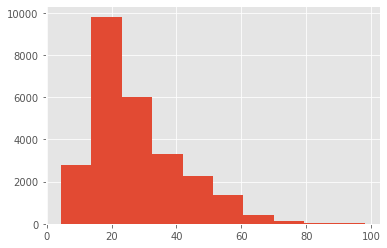

In [38]:
test_data['Energy'] = test_preds_mean
test_data['Energy'].hist()

In [39]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')
ss_df.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,63.170887
1,2023-01-01 11:00:00_B_0,71.234171
2,2023-01-01 12:00:00_B_0,70.886783
3,2023-01-01 13:00:00_B_0,70.875469
4,2023-01-01 23:00:00_B_0,78.934781


In [41]:
ss_df.to_csv("base_model_submission.csv", index=False)